# Deep Hedging AI
### Convergence to Black & Scholes Delta
#### Base case: BS with (statistical) drift 0.1, cvar@1, 400 epochs, zero cost, 50000 path
#### This file: drift is zero
Hans Buehler, January 2nd, 2023


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)


SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello ... 

2023-01-08 01:59:28.969886: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:59:28.969934: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-44-231.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist


Tensorflow version 2.7.1 running on 1 CPUs and 0 GPUs


## Deep Hedging in a Black \& Scholes World

2023-01-08 01:59:29.456656: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:59:30.556812: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Caching enabled @ '/home/ec2-user/dh_cache/2126d8c6b352d93e5f84b248492ec377.pck'
Cache successfully loaded. Current epoch: 165
Deep Hedging Engine: warming up to train 8403 weights using 236 remaining epochs over 10000 samples and 1000 validation samples ...         


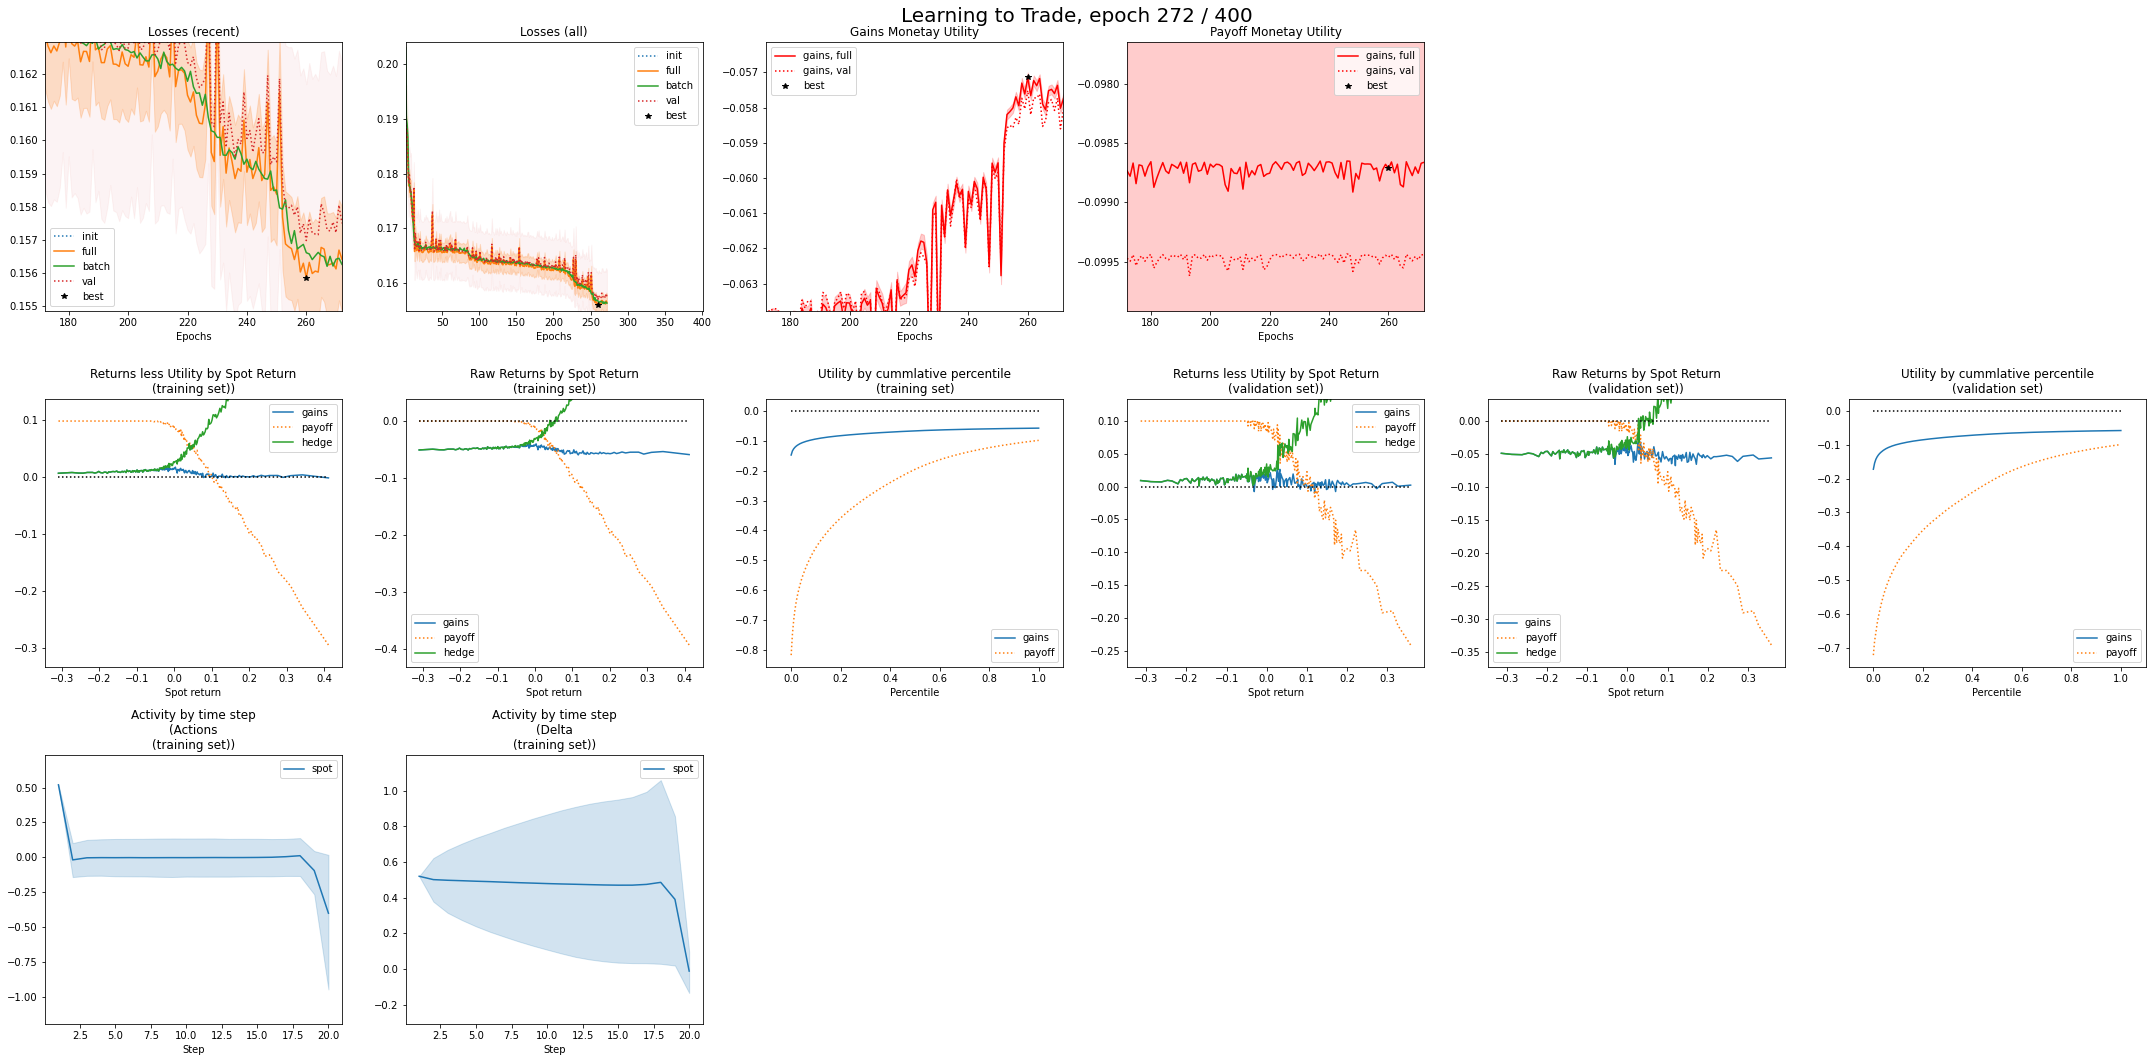

Training 272/400 epochs; 8403 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.751835 (0.0114432), full 0.156417 (0.0015869), best 0.155859 (0.0114432), batch 0.156262, val 0.157498 (0.0048653). Best epoch 259. Last cached epoch 270. | time elapsed 11:24; time per epoch 6s; estimated time remaining 13:53                            

In [ ]:
print("Deep Hedging AI says hello ... ", end='')

import importlib as imp
import deephedging.trainer as trainer
import deephedging.gym as gym
import deephedging.plot_training as plot_training

imp.reload(gym)
imp.reload(plot_training)
imp.reload(trainer)

from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
config.world.rvol = 0.2    # 20% volatility
config.world.drift = 0.    # real life drift
config.world.cost_s = 0.
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.  
config.gym.agent.network.depth = 6
config.gym.agent.network.width = 40
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer = "adam"
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.caching.epoch_freq = 10
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world & validation world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=config.world("samples")//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

In [ ]:
import deephedging.plot_bs_hedge as plot_bs_hedge
import imp
imp.reload(plot_bs_hedge)

display(Markdown("## Hedging results in detail"))
plot_bs_hedge.plot_blackscholes( world, gym, config )


In [ ]:
import tensorflow as tf
print( tf.keras.optimizers.serialize( gym.optimizer ) )
print( gym.optimizer.get_weights() )


In [ ]:
weights = gym.optimizer.get_weights()
sizes  = [ np.asarray(w).size for w in weights ]
print(sizes)
print(sum(sizes))
gym.optimizer.set_weights(weights)

weights = gym.trainable_weights
print( np.sum( [ np.prod( w.get_shape() ) for w in weights ] ) )


In [ ]:
10**9

In [ ]:
def fmt_big_number( number : int ) -> str:
    """ Big number format """
    if number >= 10**13:
        number = number//(10**9)
        number = float(number) / 1000.
        return "%gG" % number
    if number >= 10**10:
        number = number//(10**6)
        number = float(number) / 1000.
        return "%gM" % number
    if number >= 10**7:
        number = number//(10**3)
        number = float(number) / 1000.
        return "%gK" % number
    return str(number)

print(fmt_big_number(12345))
print(fmt_big_number(12345679))
print(fmt_big_number(12345678901))
print(fmt_big_number(1234567890123))
print(fmt_big_number(12345678901234))
print(fmt_big_number(1234567890123456))
print(fmt_big_number(12345678901234567890122))

In [ ]:
        weights = self.num_trainable_weights
        return np.sum( [ np.prod( w.get_shape() ) for w in weights ] )
